In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import DataLoader, TensorDataset
from itertools import product
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
import folium
from folium import plugins
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, RandomizedSearchCV

print(torch.__version__)         # 설치된 버전 출력
print(torch.cuda.is_available()) # GPU 사용 가능 여부 확인
print(torch.cuda.is_available())  # True면 사용 가능
print(torch.cuda.get_device_name())  # GPU 이름 확인

2.6.0+cu118
True
True
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [4]:
print("torch:", torch.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib:", matplotlib.__version__)

torch: 2.6.0+cu118
numpy: 1.26.4
pandas: 2.2.3
matplotlib: 3.10.1


In [544]:
data = pd.read_csv('data/(최종_v4)_서울열선_광진도로.csv')
# df.isnull().sum()
# data = df.dropna()

In [175]:
df[df['열선'] == 1][['도로종류', '도로기능', '도로규모', '도로폭']].describe()

,도로종류,도로기능,도로규모,도로폭
count,1021,1021,1021,1021
unique,1,1,7,7
top,일반도로,국지도로,소로,6m미만
freq,1021,1021,702,702


In [181]:
df['도로폭'] = df['도로폭'].fillna('6m미만')
df['도로종류'] = df['도로종류'].fillna('일반도로')
df['도로기능'] = df['도로기능'].fillna('국지도로')
df['도로규모'] = df['도로규모'].fillna('소로')
df['index']= pd.DataFrame(df.index).astype('str')
df.iloc[df[df['열선']==1].index,-1] = '열선_'+df[df['열선']==1]['index']
df.iloc[df[df['열선']==0].index,-1] = '도로_'+df[df['열선']==0]['index']

df.iloc[df[df['도로명'].isnull()]['index'].index,0] = df[df['도로명'].isnull()]['index']
data = df.drop(axis=1,labels='index')
data.to_csv('data/(최종_v3)_서울열선_광진도로.csv', index=False)

In [490]:
data[data['열선'] == 1][['종합_평균_기온', '경사각', '최근접_시설의_평균거리', '최근접_시설들_최소거리', '최근접_시설들_최대거리', '생활인구', '도로폭']].describe()

,종합_평균_기온,경사각,최근접_시설의_평균거리,최근접_시설들_최소거리,최근접_시설들_최대거리,생활인구
count,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000,1.051000e+03
mean,-1.479457,4.830660,181.108702,100.581118,251.932865,5.899831e+05
std,0.884386,3.882808,76.600147,59.232914,108.404443,3.590799e+05
min,-4.614254,0.000207,25.567593,5.719151,25.567593,1.534477e+05
25%,-2.051299,1.595178,130.842070,58.020770,183.680548,3.719204e+05
50%,-1.447241,4.097969,167.310718,91.461355,233.635076,4.847997e+05
75%,-0.890702,7.164987,217.614876,131.882083,302.885921,7.084918e+05
max,1.184111,21.868009,607.829197,416.171336,978.270885,2.515359e+06


In [492]:
data[data['열선'] == 0][['종합_평균_기온', '경사각', '최근접_시설의_평균거리', '최근접_시설들_최소거리', '최근접_시설들_최대거리', '생활인구', '도로폭']].describe()

,종합_평균_기온,경사각,최근접_시설의_평균거리,최근접_시설들_최소거리,최근접_시설들_최대거리,생활인구
count,3180.000000,3180.000000,3180.000000,3180.000000,3180.000000,3180.000000
mean,-1.543523,1.039781,169.248497,96.502700,233.337936,576341.485992
std,0.547428,1.562978,67.198427,57.383905,91.587339,151050.456554
min,-3.607125,0.000035,19.648165,3.116442,22.605030,353811.963469
25%,-1.874873,0.208717,123.187699,54.340088,169.827861,504804.480558
50%,-1.504027,0.519914,157.688696,86.989909,215.158017,582292.517720
75%,-1.145289,1.173718,198.875880,127.330386,279.525653,627107.215238
max,0.554989,15.783128,427.313651,374.439377,602.426695,933033.098567


In [127]:
data[data['열선'] == 1]['도로규모'].value_counts()

소로      702
소로3류    189
소로2류     40
소로1류     38
중로2류     31
중로1류     20
대로3류      1
Name: 도로규모, dtype: int64

In [125]:
data[data['열선'] == 0]['도로규모'].value_counts()

소로      4939
소로3류     520
소로1류      89
소로2류      85
중로1류      57
중로2류      42
광로3류       1
Name: 도로규모, dtype: int64

In [123]:
data['도로규모'].unique()

array(['중로1류', '소로', '소로3류', '소로2류', '소로1류', '대로3류', '중로2류', '광로3류'],
      dtype=object)

In [8]:
road_width = {'6m미만': 3, 
              '폭6-8m': 7, 
              '폭8-10m': 9, 
              '폭10-12m': 11, 
              '폭15-20m': 17, 
              '폭20-25m': 23, 
              '폭25-30m': 27,
              '폭40-50m': 45}
data[data.columns[-1]] = data['도로폭'].map(road_width)
# data.loc[:,'도로폭'] = data['도로폭'].map(road_width)

In [113]:
data.columns

Index(['도로명', '열선', '시작점_위도', '시작점_경도', '종료점_위도', '종료점_경도', '중앙점_위도', '중앙점_경도',
       '도로_길이', '행정구역', '고도의_차이', '경사각', '최근접_시설들_거리', '최근접_시설의_평균거리',
       '2019_평균_온도', '2020_평균_온도', '2021_평균_온도', '2022_평균_온도', '2023_평균_온도',
       '2024_평균_온도', '종합_평균_기온', '행정동', '생활인구', '최근접_시설들_최소거리', '최근접_시설들_최대거리',
       '도로종류', '도로기능', '도로규모', '도로폭'],
      dtype='object')

In [284]:
# X.columns

# i = ''
# for i in X.columns:
#     if i not in data1_test.columns:
#         print(i)
#         print(pd.Series(np.zeros(len(data1_test)), name=f'{i}'))
print(pd.Series(np.zeros(len(data1_test))))
data_test.isnull().sum()
# pd.Series(np.zeros(len(data1_test)), name=f'{i}')
# data1_test['경사각']
print(X.columns)
print(data1_test.columns)


0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1217    0.0
1218    0.0
1219    0.0
1220    0.0
1221    0.0
Length: 1222, dtype: float64
Index(['종합_평균_기온', '경사각', '최근접_시설의_평균거리', '최근접_시설들_최소거리', '최근접_시설들_최대거리',
       '생활인구', '도로폭_6m미만', '도로폭_폭10-12m', '도로폭_폭15-20m', '도로폭_폭20-25m',
       '도로폭_폭25-30m', '도로폭_폭40-50m', '도로폭_폭6-8m', '도로폭_폭8-10m'],
      dtype='object')
Index(['종합_평균_기온', '경사각', '최근접_시설의_평균거리', '최근접_시설들_최소거리', '최근접_시설들_최대거리',
       '생활인구', '도로폭_6m미만', '도로폭_폭10-12m', '도로폭_폭15-20m', '도로폭_폭20-25m',
       '도로폭_폭40-50m', '도로폭_폭6-8m', '도로폭_폭8-10m', '도로폭_폭25-30m'],
      dtype='object')


In [913]:
X = pd.get_dummies(data[['종합_평균_기온', '경사각', '최근접_시설의_평균거리', '최근접_시설들_최소거리', '최근접_시설들_최대거리', '생활인구', '도로폭']])
X = X[['종합_평균_기온', '경사각', '최근접_시설의_평균거리', '최근접_시설들_최소거리', '최근접_시설들_최대거리', '생활인구', '도로폭_6m미만',
       '도로폭_폭6-8m', '도로폭_폭8-10m', '도로폭_폭10-12m', '도로폭_폭15-20m', '도로폭_폭20-25m', '도로폭_폭25-30m', '도로폭_폭40-50m']]
y = data['열선']

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)
X_train = X_train.astype('float')
X_val = X_val.astype('float')
X = X.astype('float')

data1 = data.loc[X_val.index,:]
data1_test = pd.get_dummies(data1[data1['열선'] == 0][['종합_평균_기온', '경사각', '최근접_시설의_평균거리', '최근접_시설들_최소거리', '최근접_시설들_최대거리', '생활인구', '도로폭']])
for i in X.columns:
    if i not in data1_test.columns:
        data1_test[i] = np.zeros(len(data1_test))
data1_test = data1_test[['종합_평균_기온', '경사각', '최근접_시설의_평균거리', '최근접_시설들_최소거리', '최근접_시설들_최대거리', '생활인구', '도로폭_6m미만',
       '도로폭_폭6-8m', '도로폭_폭8-10m', '도로폭_폭10-12m', '도로폭_폭15-20m', '도로폭_폭20-25m', '도로폭_폭25-30m', '도로폭_폭40-50m']]
data1_test = data1_test.astype('float')
data_test = pd.get_dummies(data[data['열선'] == 0][['종합_평균_기온', '경사각', '최근접_시설의_평균거리', '최근접_시설들_최소거리', '최근접_시설들_최대거리', '생활인구', '도로폭']])
for i in X.columns:
    if i not in data_test.columns:
        data_test[i] = np.zeros(len(data_test))
data_test = data_test[['종합_평균_기온', '경사각', '최근접_시설의_평균거리', '최근접_시설들_최소거리', '최근접_시설들_최대거리', '생활인구', '도로폭_6m미만',
       '도로폭_폭6-8m', '도로폭_폭8-10m', '도로폭_폭10-12m', '도로폭_폭15-20m', '도로폭_폭20-25m', '도로폭_폭25-30m', '도로폭_폭40-50m']]
data_test = data_test.astype('float')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # fit + transform
X_val_scaled = scaler.transform(X_val)         # transform only
X_scaled = scaler.transform(X)
data_test_scaled = scaler.transform(data_test)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val = torch.tensor(y_val.to_numpy(), dtype=torch.float32)
data_test = torch.tensor(data_test_scaled, dtype=torch.float32)

In [496]:
len(X.columns)

14

In [324]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 1. 커스텀 MLP 모델 클래스
class FeatureWeightedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32], manual_weights=None, activation='relu', dropout_rate=0.0):
        super().__init__()

        self.learned_weights = nn.Parameter(torch.randn(input_dim))

        if manual_weights is not None:
            self.manual_weights = torch.tensor(manual_weights, dtype=torch.float32).to(device)
        else:
            self.manual_weights = None

        self.layers = nn.ModuleList()
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            prev_dim = hidden_dim

        self.output_layer = nn.Linear(prev_dim, 1)

        self.activation = activation
        self.dropout_rate = dropout_rate

    def forward(self, x):
        attention_raw = self.learned_weights

        if self.manual_weights is not None:
            attention_combined = attention_raw + self.manual_weights
        else:
            attention_combined = attention_raw

        attention = F.softmax(attention_combined, dim=0)

        x = x * attention
        for layer in self.layers:
            x = layer(x)
            x = self._get_activation(x)
            if self.dropout_rate > 0.0:
                x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = torch.sigmoid(self.output_layer(x))
        return x

    def _get_activation(self, x):
        if self.activation == 'relu':
            return F.relu(x)
        elif self.activation == 'tanh':
            return torch.tanh(x)
        elif self.activation == 'leaky_relu':
            return F.leaky_relu(x)
        elif self.activation == 'elu':
            return F.elu(x)
        elif self.activation == 'gelu':
            return F.gelu(x)
        else:
            return x

# 2. 학습 함수
def train_model(model, X_train, y_train, X_val=None, y_val=None, lr=1e-3, epochs=500, patience=None):
    set_seed(42)
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    if X_val is not None:
        X_val = X_val.to(device)
        y_val = y_val.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    best_score = 0
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()

        optimizer.zero_grad()
        y_pred = model(X_train).squeeze()
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

        if patience is not None:
            if X_val is not None and y_val is not None:
                model.eval()
                with torch.no_grad():
                    val_probs = model(X_val).squeeze().detach().cpu().numpy()
                    val_labels = y_val.detach().cpu().numpy()
                    pr_auc = average_precision_score(val_labels, val_probs)

                if pr_auc > best_score:
                    best_score = pr_auc
                    best_model_state = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"⏹ Early stopping at epoch {epoch+1}, PR AUC: {pr_auc:.4f}")
                        break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

# 3. 평가 함수
def evaluate_model(model, X_val, y_val):
    model = model.to(device)
    X_val = X_val.to(device)
    y_val = y_val.to(device)

    model.eval()
    with torch.no_grad():
        y_probs = model(X_val).squeeze().cpu().numpy()
        y_true = y_val.cpu().numpy()

    roc_auc = roc_auc_score(y_true, y_probs)
    pr_auc = average_precision_score(y_true, y_probs)
    return roc_auc, pr_auc

# 4. 교차검증 함수
def cross_validate_model(X, y, manual_weights=None, k=5, hidden_dims=[64, 32], activation='relu', dropout_rate=0.0, lr=1e-3):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    roc_aucs, pr_aucs = [], []

    for train_idx, val_idx in skf.split(X, y):
        X_train = X[train_idx].clone().detach().to(device)
        y_train = y[train_idx].clone().detach().to(device)
        X_val = X[val_idx].clone().detach().to(device)
        y_val = y[val_idx].clone().detach().to(device)

        manual_w = torch.tensor(manual_weights, dtype=torch.float32).to(device) if manual_weights is not None else None

        model = FeatureWeightedMLP(input_dim=X.shape[1], hidden_dims=hidden_dims, manual_weights=manual_w)
        model.activation = activation
        model.dropout_rate = dropout_rate

        train_model(model, X_train, y_train, X_val, y_val, lr=lr)
        roc, pr = evaluate_model(model, X_val, y_val)
        roc_aucs.append(roc)
        pr_aucs.append(pr)

    print(f"ROC AUC (mean ± std): {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}")
    print(f"PR AUC  (mean ± std): {np.mean(pr_aucs):.4f} ± {np.std(pr_aucs):.4f}")
    return np.mean(roc_aucs), np.mean(pr_aucs)

# 5. 랜덤 서치 함수
def random_search_mlp(X, y, param_grid, n_trials=10, k=3):
    results = []
    d = X.shape[1]

    for i in range(n_trials):
        config = {key: random.choice(values) for key, values in param_grid.items()}
        print(f"▶️ Trial {i+1}/{n_trials} | Config: {config}")

        roc_auc, pr_auc = cross_validate_model(
            X, y,
            hidden_dims=config['hidden_dims'],
            activation=config['activation'],
            dropout_rate=config['dropout_rate'],
            lr=config['lr'],
            k=k
        )

        results.append({
            "config": config,
            "roc_auc": roc_auc,
            "pr_auc": pr_auc
        })

    return sorted(results, key=lambda x: x['pr_auc'], reverse=True)

In [642]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 커스텀 MLP 모델 클래스
class FeatureWeightedMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32], manual_weights=None, activation='relu', dropout_rate=0.0):
        super().__init__()

        self.learned_weights = nn.Parameter(torch.randn(input_dim))

        if manual_weights is not None:
            self.manual_weights = torch.tensor(manual_weights, dtype=torch.float32).to(device)
        else:
            self.manual_weights = None

        self.layers = nn.ModuleList()
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            prev_dim = hidden_dim

        self.output_layer = nn.Linear(prev_dim, 1)

        self.activation = activation
        self.dropout_rate = dropout_rate

    def forward(self, x):
        attention_raw = self.learned_weights

        if self.manual_weights is not None:
            attention_combined = attention_raw + self.manual_weights
        else:
            attention_combined = attention_raw

        attention = F.softmax(attention_combined, dim=0)

        x = x * attention
        for layer in self.layers:
            x = layer(x)
            x = self._get_activation(x)
            if self.dropout_rate > 0.0:
                x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = torch.sigmoid(self.output_layer(x))
        return x

    def _get_activation(self, x):
        if self.activation == 'relu':
            return F.relu(x)
        elif self.activation == 'tanh':
            return torch.tanh(x)
        elif self.activation == 'leaky_relu':
            return F.leaky_relu(x)
        elif self.activation == 'elu':
            return F.elu(x)
        elif self.activation == 'gelu':
            return F.gelu(x)
        else:
            return x

# 2. 학습 함수
def train_model(model, X_train, y_train, X_val=None, y_val=None, lr=1e-3, epochs=500, patience=None, batch_size=1024):
    set_seed(42)
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    if X_val is not None:
        X_val = X_val.to(device)
        y_val = y_val.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    best_score = 0
    best_model_state = None
    patience_counter = 0

    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in loader:
            optimizer.zero_grad()
            y_pred = model(batch_X).squeeze()
            loss = criterion(y_pred, batch_y)
            loss.backward()
            optimizer.step()

        if patience is not None:
            if X_val is not None and y_val is not None:
                model.eval()
                with torch.no_grad():
                    val_probs = model(X_val).squeeze().detach().cpu().numpy()
                    val_labels = y_val.detach().cpu().numpy()
                    pr_auc = average_precision_score(val_labels, val_probs)

                if pr_auc > best_score:
                    best_score = pr_auc
                    best_model_state = model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"⏹ Early stopping at epoch {epoch+1}, PR AUC: {pr_auc:.4f}")
                        break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

# 3. 평가 함수
def evaluate_model(model, X_val, y_val):
    model = model.to(device)
    X_val = X_val.to(device)
    y_val = y_val.to(device)

    model.eval()
    with torch.no_grad():
        y_probs = model(X_val).squeeze().cpu().numpy()
        y_true = y_val.cpu().numpy()

    roc_auc = roc_auc_score(y_true, y_probs)
    pr_auc = average_precision_score(y_true, y_probs)
    return roc_auc, pr_auc

# 4. 교차검증 함수
def cross_validate_model(X, y, manual_weights=None, k=5, hidden_dims=[64, 32], activation='relu', dropout_rate=0.0, lr=1e-3, batch_size=1024):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    roc_aucs, pr_aucs = [], []

    for train_idx, val_idx in skf.split(X, y):
        X_train = X[train_idx].clone().detach().to(device)
        y_train = y[train_idx].clone().detach().to(device)
        X_val = X[val_idx].clone().detach().to(device)
        y_val = y[val_idx].clone().detach().to(device)

        manual_w = torch.tensor(manual_weights, dtype=torch.float32).to(device) if manual_weights is not None else None

        model = FeatureWeightedMLP(input_dim=X.shape[1], hidden_dims=hidden_dims, manual_weights=manual_w)
        model.activation = activation
        model.dropout_rate = dropout_rate

        train_model(model, X_train, y_train, X_val, y_val, lr=lr, batch_size=batch_size)
        roc, pr = evaluate_model(model, X_val, y_val)
        roc_aucs.append(roc)
        pr_aucs.append(pr)

    print(f"ROC AUC (mean ± std): {np.mean(roc_aucs):.4f} ± {np.std(roc_aucs):.4f}")
    print(f"PR AUC  (mean ± std): {np.mean(pr_aucs):.4f} ± {np.std(pr_aucs):.4f}")
    return np.mean(roc_aucs), np.mean(pr_aucs)

# 5. 랜덤 서치 함수
def random_search_mlp(X, y, param_grid, n_trials=10, k=3):
    results = []
    d = X.shape[1]

    for i in range(n_trials):
        config = {key: random.choice(values) for key, values in param_grid.items()}
        print(f"▶️ Trial {i+1}/{n_trials} | Config: {config}")

        roc_auc, pr_auc = cross_validate_model(
            X, y,
            hidden_dims=config['hidden_dims'],
            activation=config['activation'],
            dropout_rate=config['dropout_rate'],
            lr=config['lr'],
            batch_size=config['batch_size'],
            k=k
        )

        results.append({
            "config": config,
            "roc_auc": roc_auc,
            "pr_auc": pr_auc
        })

    return sorted(results, key=lambda x: x['pr_auc'], reverse=True)

In [292]:
# ✅ 종합 중요도 계산 (attention × 중간층 가중치)
def compute_combined_importance(model, X):
    model.eval()
    with torch.no_grad():
        # 1. 입력층 attention 계산 (정규화 포함)
        attention_raw = F.relu(model.learned_weights)
        if model.manual_weights is not None:
            attention_combined = attention_raw + model.manual_weights
        else:
            attention_combined = attention_raw
        attention = F.softmax(attention_combined, dim=0).cpu().numpy()

        # 2. 첫 번째 선형층의 절댓값 평균으로 중요도 반영 (중간층 가중치 영향)
        first_linear_weights = model.layers[0].weight.abs().cpu().numpy()  # shape: [hidden_dim, input_dim]
        middle_weights = first_linear_weights.mean(axis=0)  # shape: [input_dim]

        # 3. 곱해주고 정규화
        combined_importance = attention * middle_weights
        combined_importance /= combined_importance.sum()

    # 🔸 특성 이름 설정
    if hasattr(X, "columns"):
        feature_names = X.columns
    else:
        feature_names = [f"Feature {i}" for i in range(len(combined_importance))]

    # 🔸 정렬 및 시각화
    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Combined Importance": combined_importance
    }).sort_values(by="Combined Importance", ascending=False).reset_index(drop=True)

    print(importance_df.head(15))

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Combined Importance"])
    plt.xlabel("Importance (attention × middle weights)")
    plt.title("Combined Feature Importance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    return importance_df

In [294]:
# 전체 시드 고정 코드 (한 번만 실행하면 됨)
def set_seed(seed=42):
    # random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # GPU에서도 고정
    torch.cuda.manual_seed_all(seed)  # multi-GPU 사용 시
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [413]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # fit + transform
X_val_scaled = scaler.transform(X_val)
print(f'X_train.columns= {len(X_train.columns)}')
print(f'X_val.columns= {len(X_val.columns)}')

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
X_val = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val = torch.tensor(y_val.to_numpy(), dtype=torch.float32)
print(f'X_train.shape= {X_train.shape}')
print(f'X_val.shape= {X_val.shape}')
# model = FeatureWeightedMLP(input_dim=15, manual_weights=np.ones(15), hidden_dims=[128, 64])
# train_model(model, X_train, y_train, epochs=100)
# evaluate_model(model, X_val, y_val)

X_train.columns= 7
X_val.columns= 7
X_train.shape= torch.Size([5727, 7])
X_val.shape= torch.Size([1432, 7])


In [644]:
param_grid = {
    'hidden_dims': [
        [256, 128, 64],
        [128, 96, 64, 32],
        [512, 128, 32],
        [512, 256, 128, 64],
        [512, 256, 64]
    ],
    'activation': [
        'tanh'
    ],
    'dropout_rate': [0.15, 0.2, 0.25],
    'lr': [ 0.003, 0.005, 0.008, 0.01, 0.015, 0.018],
    'batch_size': [32, 64, 128, 256, 512, 1024, 2048, 4096]
}
# param_grid = {
#     'hidden_dims': [[512, 256, 128, 64]],
#     'activation': [
#         'tanh'
#     ],
#     'dropout_rate': [0.0, 0.1, 0.15, 0.2, 0.25],
#     'lr': [0.001, 0.002, 0.003, 0.005, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015]
#     # 'batch_size': [32, 64, 128, 256, 512, 1024, 2048, 4096]
# }

In [646]:
random_search_mlp(X_train, y_train, param_grid, n_trials=120, k=5)

▶️ Trial 1/120 | Config: {'hidden_dims': [256, 128, 64], 'activation': 'tanh', 'dropout_rate': 0.15, 'lr': 0.018, 'batch_size': 256}
ROC AUC (mean ± std): 0.9358 ± 0.0074
PR AUC  (mean ± std): 0.8711 ± 0.0183
▶️ Trial 2/120 | Config: {'hidden_dims': [512, 128, 32], 'activation': 'tanh', 'dropout_rate': 0.25, 'lr': 0.015, 'batch_size': 128}
ROC AUC (mean ± std): 0.9253 ± 0.0138
PR AUC  (mean ± std): 0.8572 ± 0.0234
▶️ Trial 3/120 | Config: {'hidden_dims': [512, 256, 128, 64], 'activation': 'tanh', 'dropout_rate': 0.25, 'lr': 0.003, 'batch_size': 64}
ROC AUC (mean ± std): 0.9381 ± 0.0076
PR AUC  (mean ± std): 0.8819 ± 0.0131
▶️ Trial 4/120 | Config: {'hidden_dims': [512, 256, 128, 64], 'activation': 'tanh', 'dropout_rate': 0.15, 'lr': 0.008, 'batch_size': 32}
ROC AUC (mean ± std): 0.9202 ± 0.0110
PR AUC  (mean ± std): 0.8507 ± 0.0209
▶️ Trial 5/120 | Config: {'hidden_dims': [512, 256, 64], 'activation': 'tanh', 'dropout_rate': 0.2, 'lr': 0.008, 'batch_size': 512}
ROC AUC (mean ± std): 0.

[{'config': {'hidden_dims': [256, 128, 64],
   'activation': 'tanh',
   'dropout_rate': 0.15,
   'lr': 0.01,
   'batch_size': 128},
  'roc_auc': 0.9411033833875863,
  'pr_auc': 0.8904075988154914},
 {'config': {'hidden_dims': [256, 128, 64],
   'activation': 'tanh',
   'dropout_rate': 0.2,
   'lr': 0.015,
   'batch_size': 2048},
  'roc_auc': 0.9377500073318062,
  'pr_auc': 0.8871058198231971},
 {'config': {'hidden_dims': [256, 128, 64],
   'activation': 'tanh',
   'dropout_rate': 0.25,
   'lr': 0.005,
   'batch_size': 1024},
  'roc_auc': 0.9407488781879658,
  'pr_auc': 0.886033812540545},
 {'config': {'hidden_dims': [256, 128, 64],
   'activation': 'tanh',
   'dropout_rate': 0.15,
   'lr': 0.018,
   'batch_size': 4096},
  'roc_auc': 0.9364895487804775,
  'pr_auc': 0.885385539350785},
 {'config': {'hidden_dims': [256, 128, 64],
   'activation': 'tanh',
   'dropout_rate': 0.15,
   'lr': 0.015,
   'batch_size': 512},
  'roc_auc': 0.9373984703210045,
  'pr_auc': 0.8846896205502706},
 {'con

In [812]:
model = FeatureWeightedMLP(input_dim=14, hidden_dims=[128, 96, 64, 32],
                           activation= 'tanh', dropout_rate= 0.2)
train_model(model, X_train, y_train, X_val, y_val, lr=0.008, batch_size=512)
train_probs = model(X_train.to(device)).squeeze().detach().cpu().numpy()
train_roc = roc_auc_score(y_train, train_probs)
train_pr = average_precision_score(y_train, train_probs)
print("Train ROC AUC:", train_roc)
print("Train PR AUC :", train_pr)
val_roc, val_pr = evaluate_model(model, X_val, y_val)
print("Val   ROC AUC:", val_roc)
print("Val   PR  AUC:", val_pr)
cross_validate_model(X_train, y_train, k=5, hidden_dims=[128, 96, 64, 32],
                     activation='tanh', lr=0.008, dropout_rate=0.2, batch_size=512)

Train ROC AUC: 0.9665662305893916
Train PR AUC : 0.9332424275087968
Val   ROC AUC: 0.9212095520700863
Val   PR  AUC: 0.8496368918684126


KeyboardInterrupt: 

         Feature  Importance
0      도로 종류_3차로    0.239811
1           생활인구    0.135628
2            경사각    0.095332
3       종합_평균_기온    0.088901
4    도로폭_폭20-25m    0.070237
5    도로폭_폭15-20m    0.069535
6    도로폭_폭10-12m    0.064494
7       도로폭_6m미만    0.044739
8   도로 종류_주거지 도로    0.044729
9   최근접_시설의_평균거리    0.044037
10  최근접_시설들_최대거리    0.037998
11    도로 종류_생활도로    0.024188
12    도로폭_폭8-10m    0.017029
13  최근접_시설들_최소거리    0.014895
14     도로폭_폭6-8m    0.008449


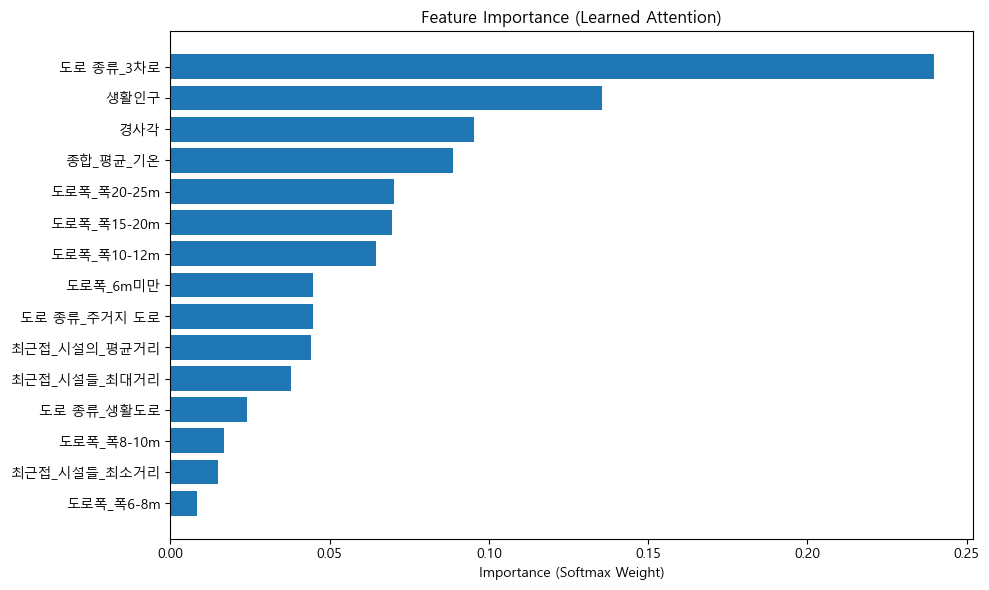

In [605]:
##### 🔹 중요도 정규화 (softmax)
with torch.no_grad():
    importance = F.softmax(model.learned_weights, dim=0).cpu().numpy()

# 🔹 특성 이름 설정
if hasattr(X, "columns"):
    feature_names = X.columns
else:
    feature_names = [f"Feature {i}" for i in range(len(importance))]

# 🔹 중요도 정렬
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importance
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

# 🔹 출력 (상위 10개만 예시)
print(importance_df.head(15))

# 🔹 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance (Softmax Weight)")
plt.title("Feature Importance (Learned Attention)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

         Feature  Importance
0            경사각    0.965037
1       종합_평균_기온    0.008041
2    도로폭_폭15-20m    0.006956
3       도로폭_6m미만    0.006047
4   최근접_시설의_평균거리    0.002969
5   도로 종류_주거지 도로    0.002621
6    도로폭_폭10-12m    0.002293
7      도로 종류_3차로    0.002235
8    도로폭_폭20-25m    0.001979
9           생활인구    0.001604
10  최근접_시설들_최소거리    0.000044
11  최근접_시설들_최대거리    0.000044
12    도로 종류_생활도로    0.000044
13     도로폭_폭6-8m    0.000044
14    도로폭_폭8-10m    0.000044


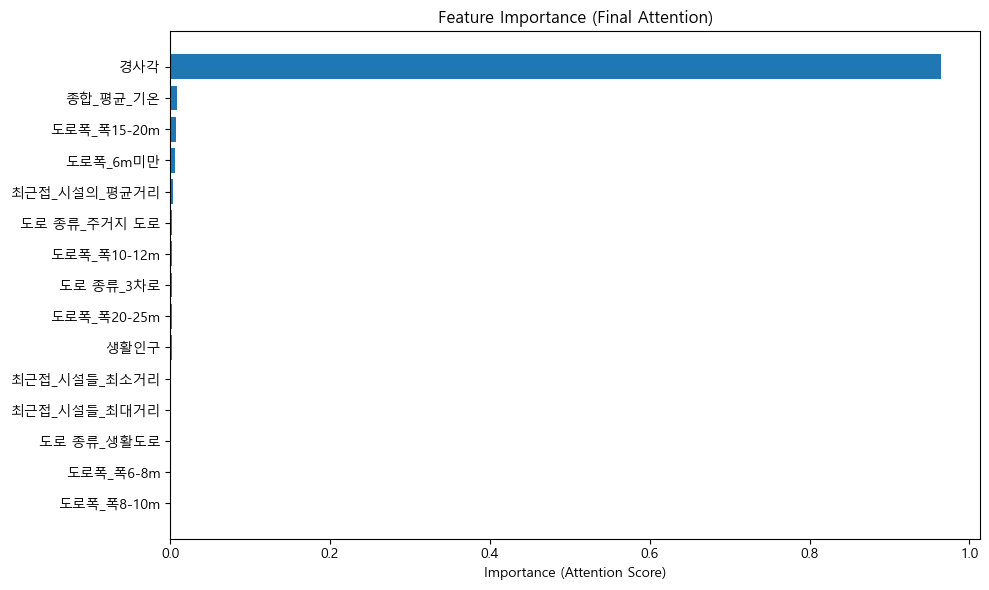

In [669]:
# 🔹 중요도 계산: 실제 attention 값 기반 (learned + manual → softmax)
with torch.no_grad():
    # 1. 기본 가중치 ReLU → 음수 제거
    attention_raw = F.relu(model.learned_weights)

    # 2. manual_weights 적용
    if model.manual_weights is not None:
        attention_combined = attention_raw + model.manual_weights
    else:
        attention_combined = attention_raw

    # 3. Softmax 정규화 → 최종 attention (입력에 곱해지는 가중치)
    attention = F.softmax(attention_combined, dim=0).cpu().numpy()

# 🔹 특성 이름
if hasattr(X, "columns"):
    feature_names = X.columns
else:
    feature_names = [f"Feature {i}" for i in range(len(attention))]

# 🔹 중요도 정렬
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": attention
}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

# 🔹 출력 (상위 15개)
print(importance_df.head(15))

# 🔹 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance (Attention Score)")
plt.title("Feature Importance (Final Attention)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

         Feature  Combined Importance
0           생활인구             0.189989
1            경사각             0.139896
2       종합_평균_기온             0.131208
3   최근접_시설의_평균거리             0.100034
4   최근접_시설들_최대거리             0.078913
5    도로폭_폭15-20m             0.059553
6   최근접_시설들_최소거리             0.058855
7     도로폭_폭8-10m             0.050207
8       도로폭_6m미만             0.049284
9      도로폭_폭6-8m             0.042339
10   도로폭_폭20-25m             0.035903
11   도로폭_폭10-12m             0.034765
12   도로폭_폭40-50m             0.017589
13   도로폭_폭25-30m             0.011465


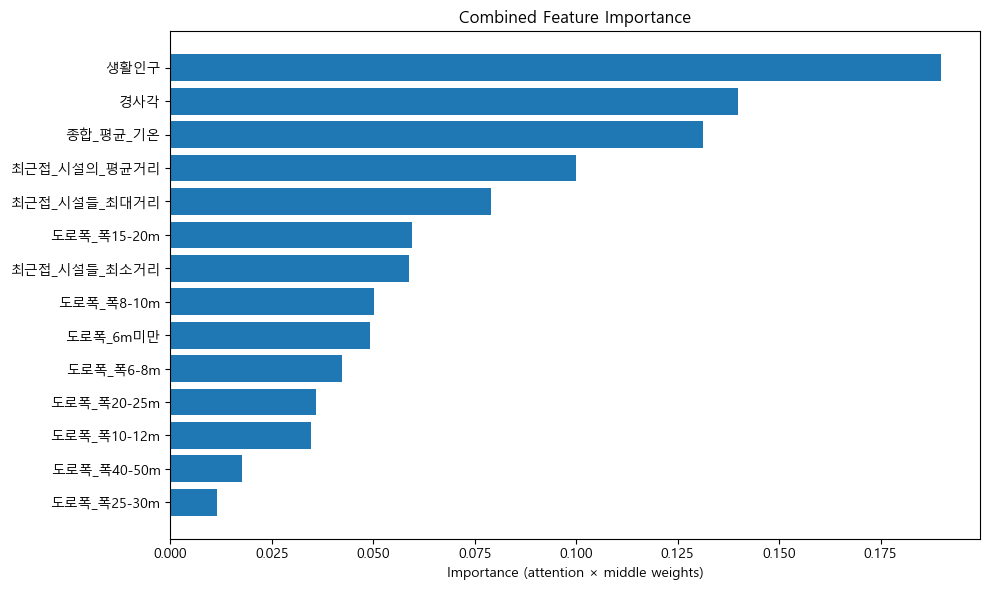

,Feature,Combined Importance
0,생활인구,0.189989
1,경사각,0.139896
2,종합_평균_기온,0.131208
3,최근접_시설의_평균거리,0.100034
4,최근접_시설들_최대거리,0.078913
5,도로폭_폭15-20m,0.059553
6,최근접_시설들_최소거리,0.058855
7,도로폭_폭8-10m,0.050207
8,도로폭_6m미만,0.049284
9,도로폭_폭6-8m,0.042339


In [1133]:
compute_combined_importance(model, X)

In [831]:
X.columns

Index(['종합_평균_기온', '경사각', '최근접_시설의_평균거리', '최근접_시설들_최소거리', '최근접_시설들_최대거리',
       '생활인구', '도로폭_6m미만', '도로폭_폭6-8m', '도로폭_폭8-10m', '도로폭_폭10-12m',
       '도로폭_폭15-20m', '도로폭_폭20-25m', '도로폭_폭25-30m', '도로폭_폭40-50m'],
      dtype='object')

In [1224]:
manual_weights = np.zeros(14)
# manual_weights[1] = 1
manual_weights[2] = 1
model = FeatureWeightedMLP(input_dim=14, hidden_dims=[512, 128, 32],
                           activation= 'tanh', dropout_rate= 0.25, manual_weights=manual_weights)
train_model(model, X_train, y_train, X_val, y_val, lr=0.003, batch_size=256)
train_probs = model(data_test.to(device)).squeeze().detach().cpu().numpy()
train_probs_df = pd.DataFrame(train_probs)
train_probs_df.index = train_probs_df.index+1051
train_probs_df = train_probs_df.sort_values(ascending=False, by=0)
probs_df = data.loc[train_probs_df.index,:]
probs_df['점수'] = train_probs_df
probs_df_dsc = probs_df
probs_df = probs_df[['도로명', '시작점_위도', '시작점_경도', '종료점_위도', '종료점_경도', 
                     '중앙점_위도', '중앙점_경도', '도로_길이', '경사각', '점수']]
probs_df = pd.concat([probs_df[['도로명', '시작점_위도', '시작점_경도', '종료점_위도', '종료점_경도', '중앙점_위도', '중앙점_경도']],
                      round(probs_df[['도로_길이', '경사각', '점수']], 4)], axis=1)
probs_df_print = probs_df[['도로명', '시작점_위도', '시작점_경도', '종료점_위도', '종료점_경도', '도로_길이', '경사각', '점수']]

In [1225]:
probs_df = data.loc[train_probs_df.index,:]
probs_df['점수'] = train_probs_df
probs_df_print = pd.concat([probs_df[['도로명', '시작점_위도', '시작점_경도', '종료점_위도', '종료점_경도']],
                      round(probs_df[['도로_길이', '최근접_시설의_평균거리', '점수']], 4)], axis=1)
probs_df_print.columns = ['도로명', '시작점_위도', '시작점_경도', '종료점_위도', '종료점_경도', '도로_길이', '시설_평균거리', '점수']
probs_df_print.iloc[:5,:]#.style.apply(draw_color_at,color='#c1ff72',subset=['도로_길이'],axis=0)

,도로명,시작점_위도,시작점_경도,종료점_위도,종료점_경도,도로_길이,시설_평균거리,점수
1866,천호대로,37.547279,127.098210,37.547323,127.098220,4.9857,300.2522,0.9950
4196,용마산로22길,37.563693,127.088392,37.563666,127.088213,16.0415,155.2037,0.9915
3485,용마산로33길,37.570134,127.085717,37.570166,127.085460,22.8955,175.8445,0.9847
3318,광장로1가길,37.547544,127.101214,37.548590,127.099650,194.0281,173.0148,0.9821
4054,능동로,37.542245,127.079583,37.542205,127.079967,34.2199,186.4337,0.9730


In [911]:
data.iloc[4054,0] = '능동로'

In [1154]:
# 도로_길이 셀 배경색 바꾸기
def draw_color_at(x, color):
    color = f'background-color:{color}'
    return [color for i in x]

length = int(input('도로 길이(m)를 입력하세요 >> '))
a = 0
while(length>0):
    length -= probs_df_print.iloc[a,-3]
    a += 1
limit = probs_df_print.iloc[:a,:]
print(f'도로개수: {a}')
limit.style.apply(draw_color_at,color='#c1ff72',subset=['도로_길이'],axis=0)

도로 길이(m)를 입력하세요 >>  2640


도로개수: 43


,도로명,시작점_위도,시작점_경도,종료점_위도,종료점_경도,도로_길이,경사각,점수
3485,용마산로33길,37.570134,127.085717,37.570166,127.085460,22.895500,6.706300,0.996000
1866,천호대로,37.547279,127.098210,37.547323,127.098220,4.985700,8.949700,0.990800
3136,도로_4411,37.551089,127.110267,37.551149,127.110722,40.704000,4.653800,0.981800
2176,도로_2585,37.539320,127.079333,37.539299,127.079084,22.069100,9.710200,0.979200
1215,천호대로140길,37.543981,127.097208,37.543848,127.098594,123.092500,2.326100,0.973600
4196,용마산로22길,37.563693,127.088392,37.563666,127.088213,16.041500,11.990500,0.970600
4203,용마산로22길,37.563552,127.087341,37.563501,127.086939,35.868300,6.217800,0.968700
3113,용마산로34길,37.570082,127.086146,37.570134,127.085717,38.238700,4.403100,0.968100
3315,광장로1길,37.548440,127.102987,37.548086,127.102283,73.502100,1.433400,0.968000
3139,아차산로78길,37.548363,127.109313,37.547361,127.107789,175.287700,1.474200,0.965000


In [1157]:
# 상위 30개 통계량 확인
print(len(probs_df_dsc[probs_df['점수']>0.7]))
round(probs_df_dsc.iloc[:30,:][['종합_평균_기온', '경사각', '최근접_시설의_평균거리', '최근접_시설들_최소거리', '최근접_시설들_최대거리', '생활인구', '도로폭']].describe(), 3)

58


,종합_평균_기온,경사각,최근접_시설의_평균거리,최근접_시설들_최소거리,최근접_시설들_최대거리,생활인구
count,30.000,30.000,30.000,30.000,30.000,30.000
mean,-1.599,5.191,177.515,99.902,245.865,634101.118
std,0.890,3.695,59.826,53.444,82.872,222514.446
min,-3.010,0.232,75.307,20.841,136.195,353811.963
25%,-2.161,2.333,137.422,55.107,182.236,457624.684
50%,-1.766,4.187,159.143,99.250,221.346,571703.540
75%,-1.025,7.163,216.100,123.417,280.531,845003.636
max,0.090,15.783,301.101,255.758,457.325,933033.099


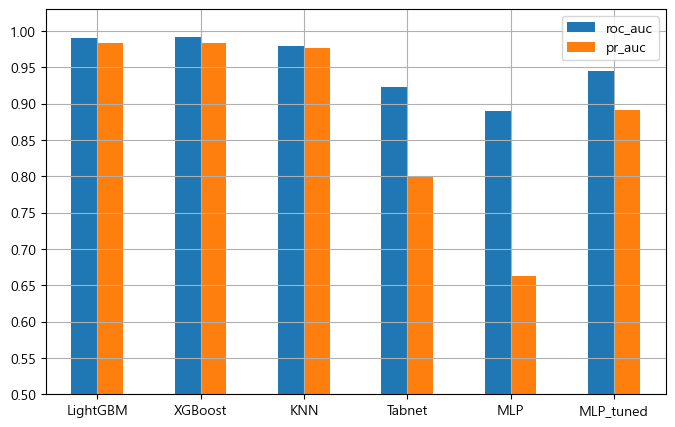

           roc_auc  pr_auc
LightGBM    0.9906  0.9838
XGBoost     0.9923  0.9831
KNN         0.9795  0.9767
Tabnet      0.9232  0.8006
MLP         0.8906  0.6634
MLP_tuned   0.9454  0.8915


In [987]:
roc_auc = [0.9906, 0.9923, 0.9795, 0.9232, 0.8906, 0.9454]
pr_auc = [0.9838, 0.9831, 0.9767, 0.8006, 0.6634, 0.8915]
index = ['LightGBM', 'XGBoost', 'KNN', 'Tabnet', 'MLP', 'MLP_tuned']
dafr = pd.DataFrame({'roc_auc': roc_auc, 'pr_auc': pr_auc}, index=index)
# df_sorted = dafr.sort_values('pr_auc', ascending=False)
dafr.plot.bar(figsize=(8, 5))
# plt.xlim(left=0.5, right=1)
plt.yticks(np.arange(0.5,1.05,0.05))
plt.ylim(0.5,1.03)
plt.xticks(rotation=0)
plt.grid()
plt.show()
print(dafr)

In [42]:
pd.concat([df[['도로명', '시작점_위도', '시작점_경도', '종료점_위도', '종료점_경도', '중앙점_위도', '중앙점_경도']], round(df[['도로_길이', '경사각', '점수']], 4)], axis=1)

,도로명,시작점_위도,시작점_경도,종료점_위도,종료점_경도,중앙점_위도,중앙점_경도,도로_길이,경사각,점수
1275,능동로4길,37.530518,127.071356,37.530770,127.071469,37.530644,127.071412,29.7673,3.7500,0.9775
1352,자양강변길,37.530770,127.071469,37.530518,127.071356,37.530644,127.071412,29.7673,3.7500,0.9773
4411,도로_4411,37.551089,127.110267,37.551149,127.110722,37.551119,127.110495,40.7040,4.6538,0.9702
2567,도로_2567,37.539306,127.076927,37.539602,127.077062,37.539454,127.076994,35.0419,5.7284,0.9688
6362,도로_6362,37.539602,127.077062,37.539306,127.076927,37.539454,127.076994,35.0419,5.7284,0.9658


In [889]:
probs_df.iloc[:33,:]['도로_길이'].sum()

2764.3495000000003

In [1159]:
# 결과 html 파일로 출력
df = probs_df.iloc[:43,:]

if len(df) > 0 :
    # print(f'위도: {df['중앙점_위도'].mean()-0.005}, 경도: {df['중앙점_경도'].mean()}')
    # 시작점과 종료점의 위도, 경도를 기반으로 지도에 직선을 그립니다.
    m = folium.Map(location=[37.549742403030294, 127.09092434545454], zoom_start=14)
    
    # 데이터프레임의 각 도로에 대해 직선과 마커를 추가합니다.
    for idx, row in df.iterrows():
        # 시작점과 종료점 좌표
        start_point = [row['시작점_위도'], row['시작점_경도']]
        end_point = [row['종료점_위도'], row['종료점_경도']]
        middle_point = [(row['시작점_위도']+row['종료점_위도'])/2, (row['시작점_경도']+row['종료점_경도'])/2]
        
        # 직선을 그리기
        folium.PolyLine([start_point, end_point], color="blue", weight=5, opacity=1).add_to(m)
    
        # folium.Marker(
        #     location=middle_point,
        #     popup=f"<ul style=\"width: 120px\"><li>Index: {idx}</li><li><span>도로명: </span><span>{row['도로명']}</span></li><li>점수: {round(row['점수'],4)}</li><li>경사도: {round(row['경사각'],2)}°</li></ul>",
        #     icon=folium.Icon(color='green')
        # ).add_to(m)
    
    # 지도 출력
    try :
        save_url = './0501MLP_최종_상위43결과(평균기온+생활인구_가중치1).html'
        m.save(save_url)
        print(f"{save_url} 파일 저장 완료. ")
    except OSError as e :
        print(e)

else :
    print(f"파일 길이가 {len(df)}라 지도 제작이 불가능합니다.")

./0501MLP_최종_상위43결과(평균기온+생활인구_가중치1).html 파일 저장 완료. 


In [43]:
df[['도로명', '시작점_위도', '시작점_경도', '종료점_위도', '종료점_경도', '중앙점_위도', '중앙점_경도', '경사각', '점수']]#.to_csv('MLP예측_간단.csv')

,도로명,시작점_위도,시작점_경도,종료점_위도,종료점_경도,중앙점_위도,중앙점_경도,경사각,점수
4114,천호대로124길,37.552037,127.087244,37.551950,127.087347,37.551994,127.087295,3.745153,0.943187
5507,천호대로135길,37.550034,127.092240,37.549936,127.092219,37.549985,127.092229,7.860940,0.916618
5349,영화사로11길,37.555783,127.094816,37.555442,127.094237,37.555612,127.094527,9.658480,0.913891
5141,용마산로36길,37.570813,127.086831,37.570816,127.087184,37.570814,127.087008,19.886592,0.907840
3820,자양로23가길,37.541588,127.082481,37.541738,127.082225,37.541663,127.082353,2.317804,0.893386
4110,능동로32길,37.551950,127.087347,37.552037,127.087244,37.551994,127.087295,3.745153,0.889647
4618,천호대로124길,37.552387,127.088456,37.552318,127.089384,37.552352,127.088920,2.032322,0.881442
4385,용마산로30길,37.568677,127.088077,37.568658,127.086863,37.568667,127.087470,10.847666,0.879524
5124,용마산로33길,37.570134,127.085717,37.570166,127.085460,37.570150,127.085588,6.706317,0.877434
6791,용마산로21길,37.562467,127.085260,37.562051,127.085027,37.562259,127.085143,2.212954,0.873123


In [59]:
df[['도로명', '시작점_위도', '시작점_경도', '종료점_위도', '종료점_경도', '중앙점_위도', '중앙점_경도', '경사각', '점수']]

,도로명,시작점_위도,시작점_경도,종료점_위도,종료점_경도,중앙점_위도,중앙점_경도,경사각,점수
4114,천호대로124길,37.552037,127.087244,37.551950,127.087347,37.551994,127.087295,3.745153,0.943187
5507,천호대로135길,37.550034,127.092240,37.549936,127.092219,37.549985,127.092229,7.860940,0.916618
5349,영화사로11길,37.555783,127.094816,37.555442,127.094237,37.555612,127.094527,9.658480,0.913891
5141,용마산로36길,37.570813,127.086831,37.570816,127.087184,37.570814,127.087008,19.886592,0.907840
3820,자양로23가길,37.541588,127.082481,37.541738,127.082225,37.541663,127.082353,2.317804,0.893386
4110,능동로32길,37.551950,127.087347,37.552037,127.087244,37.551994,127.087295,3.745153,0.889647
4618,천호대로124길,37.552387,127.088456,37.552318,127.089384,37.552352,127.088920,2.032322,0.881442
4385,용마산로30길,37.568677,127.088077,37.568658,127.086863,37.568667,127.087470,10.847666,0.879524
5124,용마산로33길,37.570134,127.085717,37.570166,127.085460,37.570150,127.085588,6.706317,0.877434
6791,용마산로21길,37.562467,127.085260,37.562051,127.085027,37.562259,127.085143,2.212954,0.873123


In [61]:
pd.concat([df[['도로명', '시작점_위도', '시작점_경도', '종료점_위도', '종료점_경도', '중앙점_위도', '중앙점_경도']], round(df[['경사각', '점수']], 4)], axis=1)

,도로명,시작점_위도,시작점_경도,종료점_위도,종료점_경도,중앙점_위도,중앙점_경도,경사각,점수
4114,천호대로124길,37.552037,127.087244,37.551950,127.087347,37.551994,127.087295,3.7452,0.9432
5507,천호대로135길,37.550034,127.092240,37.549936,127.092219,37.549985,127.092229,7.8609,0.9166
5349,영화사로11길,37.555783,127.094816,37.555442,127.094237,37.555612,127.094527,9.6585,0.9139
5141,용마산로36길,37.570813,127.086831,37.570816,127.087184,37.570814,127.087008,19.8866,0.9078
3820,자양로23가길,37.541588,127.082481,37.541738,127.082225,37.541663,127.082353,2.3178,0.8934
4110,능동로32길,37.551950,127.087347,37.552037,127.087244,37.551994,127.087295,3.7452,0.8896
4618,천호대로124길,37.552387,127.088456,37.552318,127.089384,37.552352,127.088920,2.0323,0.8814
4385,용마산로30길,37.568677,127.088077,37.568658,127.086863,37.568667,127.087470,10.8477,0.8795
5124,용마산로33길,37.570134,127.085717,37.570166,127.085460,37.570150,127.085588,6.7063,0.8774
6791,용마산로21길,37.562467,127.085260,37.562051,127.085027,37.562259,127.085143,2.2130,0.8731


In [133]:
df1 = data.loc[train_probs_df.iloc[:,0].index,:]
df1['점수'] = train_probs_df.iloc[:,0]
df1.to_csv('MLP예측_전체.csv')

torch.Size([6108, 15])

In [335]:
df['proba'] = train_probs_df.iloc[:15,0]

,도로명,열선,도로 종류,시작점_위도,시작점_경도,종료점_위도,종료점_경도,중앙점_위도,중앙점_경도,도로_길이,...,2020_평균_온도,2021_평균_온도,2022_평균_온도,2023_평균_온도,2024_평균_온도,종합_평균_기온,행정동,생활인구,최근접_시설들_최소거리,최근접_시설들_최대거리
6359,명일로,0,주거지 도로,37.539403,127.072451,37.540288,127.072915,37.539845,127.072683,106.553955,...,1.213289,-4.605434,-4.655337,-7.538266,-2.760729,-2.391801,화양동,933033.098567,143.955629,331.863183
4448,천호대로131길,0,주거지 도로,37.551433,127.090201,37.551606,127.090782,37.551520,127.090491,54.692058,...,2.108810,-1.985180,-3.142522,-3.808352,-1.890843,-0.568544,구의2동,457624.683629,93.351284,177.556543
6676,용마산로21길,0,주거지 도로,37.563386,127.085744,37.564430,127.086770,37.563908,127.086257,160.243912,...,2.469412,-4.588344,-5.544706,-4.753093,-3.444902,-2.071998,중곡3동,353811.963469,105.005913,147.354479
6538,용마산로33길,0,주거지 도로,37.570288,127.084477,37.570216,127.085041,37.570252,127.084759,50.290783,...,0.892565,-3.776222,-5.453787,-8.483349,-3.597004,-2.680624,중곡3동,353811.963469,77.618983,188.181373
4445,천호대로131길,0,주거지 도로,37.551606,127.090782,37.551433,127.090201,37.551520,127.090491,54.692058,...,2.108810,-1.985180,-3.142522,-3.808352,-1.890843,-0.568544,구의2동,457624.683629,93.351284,177.556543
4420,아차산로78길,0,주거지 도로,37.551149,127.110722,37.551074,127.110922,37.551111,127.110822,23.499120,...,0.907946,-1.773946,-1.980566,-2.117571,-1.405104,-0.327348,광장동,845003.636200,55.902965,414.241340
5124,용마산로33길,0,주거지 도로,37.570134,127.085717,37.570166,127.085460,37.570150,127.085588,22.895493,...,0.880032,-4.307383,-5.683478,-8.637160,-3.897220,-2.936804,중곡3동,353811.963469,143.961622,219.685825
4424,아차산로78가길,0,주거지 도로,37.549996,127.109543,37.548363,127.109313,37.549180,127.109428,194.534553,...,1.274814,-1.242102,-1.967992,-1.715384,-0.380078,0.100455,광장동,845003.636200,101.595326,301.826390
4110,능동로32길,0,주거지 도로,37.551950,127.087347,37.552037,127.087244,37.551994,127.087295,13.219157,...,1.336908,-3.093986,-4.561683,-4.522034,-2.703762,-1.450203,능동,371402.674435,114.110016,191.451916
5144,용마산로34길,0,주거지 도로,37.570074,127.086829,37.570082,127.086146,37.570078,127.086487,60.211844,...,0.418030,-4.787956,-5.916587,-5.305445,-4.072679,-2.634167,중곡4동,571703.539756,185.432082,236.317558


In [557]:
data['2020_평균_온도'].min()

-1.6128436599999816

In [559]:
data['2021_평균_온도'].min()

-7.058888859999973

In [561]:
data['2022_평균_온도'].min()

-6.734176959999968

In [563]:
data['2023_평균_온도'].min()

-11.198965584999982

In [565]:
data['2024_평균_온도'].min()

-5.750926539999976

In [553]:
data['종합_평균_기온'].min()

,도로명,열선,도로 종류,시작점_위도,시작점_경도,종료점_위도,종료점_경도,중앙점_위도,중앙점_경도,도로_길이,...,2020_평균_온도,2021_평균_온도,2022_평균_온도,2023_평균_온도,2024_평균_온도,종합_평균_기온,행정동,생활인구,최근접_시설들_최소거리,최근접_시설들_최대거리
0,일원로,1,3차로,37.491015,127.080765,37.490648,127.080938,37.490832,127.080852,43.557286,...,0.881741,-2.871131,-1.719942,-4.994405,-0.762408,-1.063733,일원1동,3.303279e+05,141.887303,267.191172
1,자곡로5길,1,주거지 도로,37.472343,127.096176,37.472057,127.094614,37.472200,127.095395,218.130971,...,0.151180,-5.008077,-2.071998,-4.362071,-1.637150,-1.766170,세곡동,1.123343e+06,62.368275,111.440940
2,삼성로112길,1,주거지 도로,37.514052,127.052859,37.514866,127.053307,37.514459,127.053083,98.751984,...,1.907717,-1.829318,-0.318553,-7.448543,-2.587549,-0.948210,삼성1동,9.879387e+05,117.137149,181.435958
3,삼성로149길,1,주거지 도로,37.523404,127.047378,37.523375,127.047124,37.523389,127.047251,22.669102,...,3.624133,-2.501301,-0.068183,-6.494916,-3.226149,-0.569161,청담동,9.285286e+05,170.745688,427.222876
4,압구정로71길,1,주거지 도로,37.528605,127.046188,37.529140,127.046384,37.528873,127.046286,61.909056,...,1.475907,-4.912372,-2.749620,-8.776444,-5.549833,-2.914910,청담동,9.285286e+05,119.573040,497.095607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7154,천호대로125길,0,주거지 도로,37.554907,127.087447,37.554335,127.087071,37.554621,127.087259,71.710310,...,1.338047,-3.413229,-4.743522,-4.331993,-2.916818,-1.541464,중곡2동,4.272949e+05,69.008444,194.735047
7155,천호대로119길,0,주거지 도로,37.556081,127.086125,37.556026,127.086131,37.556054,127.086128,6.118745,...,1.361403,-3.260785,-4.001128,-4.505628,-3.188551,-1.508119,중곡2동,4.272949e+05,116.971706,157.313387
7156,용마산로3길,0,주거지 도로,37.556081,127.086125,37.556115,127.086474,37.556098,127.086299,31.035093,...,1.361403,-3.260785,-4.001128,-4.505628,-3.188551,-1.508119,중곡2동,4.272949e+05,106.768004,156.154668
7157,천호대로119길,0,주거지 도로,37.556081,127.086125,37.557508,127.085895,37.556795,127.086010,159.957599,...,1.195629,-3.487742,-3.983354,-4.907587,-3.217604,-1.665462,중곡2동,4.272949e+05,74.678553,126.901159
